# Predicción de Futuras Ventas

In [1]:
pip install skforecast

     -------------------------------------- 397.3/397.3 kB 6.2 MB/s eta 0:00:00
     -------------------------------------- 390.6/390.6 kB 8.1 MB/s eta 0:00:00
     -------------------------------------- 226.0/226.0 kB 7.0 MB/s eta 0:00:00
     ---------------------------------------- 78.7/78.7 kB 4.3 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.1.2 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['font.size'] = 10

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregDirect import ForecasterAutoregDirect
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster
from skforecast.utils import save_forecaster
from skforecast.utils import load_forecaster

import warnings
warnings.filterwarnings('ignore')

## Cargar datos

In [3]:
df = pd.read_csv('D:/Nuevo.csv')

In [4]:
df.columns

Index(['SchemaField('Empresa', 'STRING', 'NULLABLE', None, None, (), None)',
       'SchemaField('FECHA', 'STRING', 'NULLABLE', None, None, (), None)',
       'SchemaField('Anio', 'INTEGER', 'NULLABLE', None, None, (), None)',
       'SchemaField('Mes', 'INTEGER', 'NULLABLE', None, None, (), None)',
       'SchemaField('Proveedor', 'STRING', 'NULLABLE', None, None, (), None)',
       'SchemaField('Linea', 'STRING', 'NULLABLE', None, None, (), None)',
       'SchemaField('Marca', 'STRING', 'NULLABLE', None, None, (), None)',
       'SchemaField('Producto', 'STRING', 'NULLABLE', None, None, (), None)',
       'SchemaField('Sucursal', 'STRING', 'NULLABLE', None, None, (), None)',
       'SchemaField('Cod_Cliente', 'STRING', 'NULLABLE', None, None, (), None)',
       'SchemaField('Cliente', 'STRING', 'NULLABLE', None, None, (), None)',
       'SchemaField('FuerzaVentas', 'STRING', 'NULLABLE', None, None, (), None)',
       'SchemaField('ValorVenta', 'FLOAT', 'NULLABLE', None, None, (), Non

##### Cambiamos el nombre de cada columna con la finalidad de tener un nombre específico.

In [5]:
df.columns = ['Empresa', 'Fecha', 'Año', 'Mes', 'Proveedor', 'Linea', 'Marca', 'Producto', 'Sucursal',
              'Cod_Cliente', 'Cliente', 'FuerzaVentas', 'ValorVenta', 'Cantidad']

In [6]:
df.head()

,Empresa,Fecha,Año,Mes,Proveedor,Linea,Marca,Producto,Sucursal,Cod_Cliente,Cliente,FuerzaVentas,ValorVenta,Cantidad
0,GVD,12/06/2023,2023,6,PESQUERA HAYDUK S.A.,CONSERVAS DE PESCADOS,CAMPOMAR,CAMPOMAR GRATED ATUN CJ*24*160GR,VEGA ESTE,101242,"VASCONCELLOS GONZALES, NORMA MILUSKA",RUTA Mixta C,28.677966,12.0
1,GVD,16/08/2023,2023,8,QUIMICA SUIZA SAC,MEDICINAS,SAL DE ANDREWS,SAL DE ANDREWS CJA*72DISP*30U,VEGA ESTE,233078,"DOMINGUEZ SUAREZ, LUISA CONSUELO",RUTA Mixta B,15.288136,1.0
2,GVD,21/08/2023,2023,8,GENOMMA LAB. PERU S.A.,SHAMPOO Y CUIDADO PARA EL CABELLO,TIO NACHO,CBO LOTERO:2TR TIO NACHO SH*18ML(HERBOLARIA-AC...,VEGA ESTE,106889,"VASQUEZ SALAZAR, KATHERINE ROSE MARY",RUTA Mixta C,13.576271,1.0
3,GVD,04/08/2023,2023,8,AJINOMOTO DEL PERU S A,SALSA DE SOYA,AJINOSILLAO,AJINOSILLAO CJA*96U*150ML,VEGA SUR,358590,"CisFarma ,",RUTA Mixta B,7.264576,6.0
4,GVD,22/08/2023,2023,8,ALIMENTOS POLAR PERU S.A.C.,HARINAS Y DERIVADOS,PAN,PAN HARINA PRE COCIDA BOL*20U*1KG,VEGA NORTE,139809,"SALAS ALVAREZ, ELIZABETH ANA",RUTA Mixta C,16.523644,3.0


## Preprocesamiento de datos

In [7]:
df.isnull().sum()

Empresa         0
Fecha           0
Año             0
Mes             0
Proveedor       0
Linea           0
Marca           0
Producto        0
Sucursal        0
Cod_Cliente     0
Cliente         0
FuerzaVentas    0
ValorVenta      0
Cantidad        0
dtype: int64

In [8]:
df.dtypes

Empresa          object
Fecha            object
Año               int64
Mes               int64
Proveedor        object
Linea            object
Marca            object
Producto         object
Sucursal         object
Cod_Cliente       int64
Cliente          object
FuerzaVentas     object
ValorVenta      float64
Cantidad        float64
dtype: object

##### En el conjunto de datos nos interesa dos campos, las cuales son `Fecha` y `ValorVenta`, por lo que asignaremos ambas columnas en un nuevo dataset.

In [9]:
data = df[['Fecha', 'ValorVenta']]

In [10]:
data.head()

,Fecha,ValorVenta
0,12/06/2023,28.677966
1,16/08/2023,15.288136
2,21/08/2023,13.576271
3,04/08/2023,7.264576
4,22/08/2023,16.523644


##### La columna `Fecha` se ha almacenado como `string`. Para convertirla en el formato `datetime`, se emplea la función `pd.to_datetime()`. Una vez en formato `datetime`, y para hacer uso de las funcionalidades de la librería **Pandas**, se establece como índice. Además, dado que los datos son diarios, se indica la frecuencia (D).

In [11]:
data['Fecha'] = pd.to_datetime(data['Fecha'], format='%d/%m/%Y')
data = data.set_index('Fecha')

In [12]:
data.head()

,ValorVenta
Fecha,
2023-06-12,28.677966
2023-08-16,15.288136
2023-08-21,13.576271
2023-08-04,7.264576
2023-08-22,16.523644


##### Agrupamos los datos por fecha, rellenando fechas faltantes y ordenando el DataFrame por fecha.

In [13]:
data = data.groupby(data.index).sum()

In [14]:
data = data.asfreq('D')
data = data.sort_index()
data.head()

,ValorVenta
Fecha,
2023-01-02,15.613143
2023-01-03,714858.376324
2023-01-04,837090.514947
2023-01-05,807809.046109
2023-01-06,797892.370371


In [15]:
data.isnull().sum()

ValorVenta    18
dtype: int64

In [16]:
data = data.interpolate()

##### Al establecer la frecuencia con el método `asfreq()`, **Pandas** completa los huecos que puedan existir en la serie temporal con el valor de `Null` con el fin de asegurar la frecuencia indicada. Por ello, se debe comprobar si han aparecido missing values tras esta transformación.

In [17]:
print(f'Número de filas con missing values: {data.isnull().any(axis=1).mean()}')

Número de filas con missing values: 0.0


In [18]:
(data.index == pd.date_range(
                    start = data.index.min(),
                    end   = data.index.max(),
                    freq  = data.index.freq)
).all()

True

Fechas train : 2023-01-02 00:00:00 --- 2023-07-05 00:00:00  (n=185)
Fechas test  : 2023-07-06 00:00:00 --- 2023-10-13 00:00:00  (n=100)


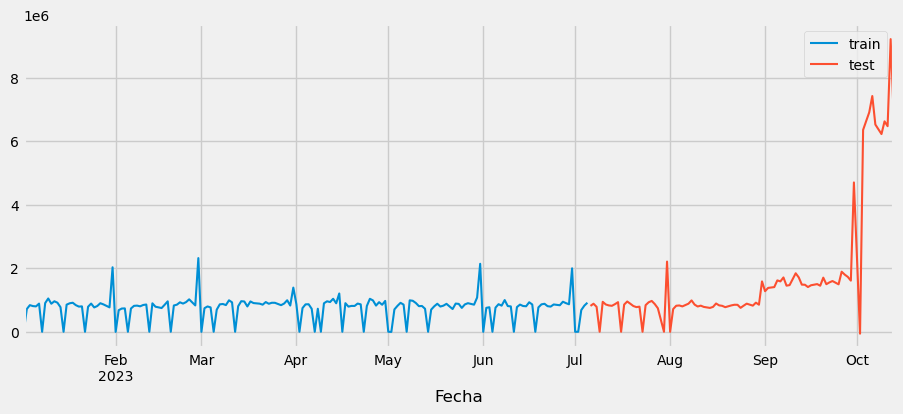

In [19]:
steps = 100
datos_train = data[:-steps]
datos_test  = data[-steps:]

print(f"Fechas train : {datos_train.index.min()} --- {datos_train.index.max()}  (n={len(datos_train)})")
print(f"Fechas test  : {datos_test.index.min()} --- {datos_test.index.max()}  (n={len(datos_test)})")

fig, ax = plt.subplots(figsize=(10, 4))
datos_train['ValorVenta'].plot(ax=ax, label='train')
datos_test['ValorVenta'].plot(ax=ax, label='test')
ax.legend();

## Forecasting autorregresivo recursivo

##### Se crea y entrena un modelo `ForecasterAutoreg` a partir de un regresor `RandomForestRegressor` y una ventana temporal de 20 lags.
##### Este último significa que, el modelo, utiliza como predictores los 20 días anteriores.

In [20]:
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags = 20
             )

forecaster.fit(datos_train['ValorVenta'])
forecaster

ForecasterAutoreg 
Regressor: RandomForestRegressor(random_state=123) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20] 
Transformer for y: None 
Transformer for exog: None 
Window size: 20 
Weight function included: False 
Differentiation order: None 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2023-01-02 00:00:00'), Timestamp('2023-07-05 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: D 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False} 
fit_kwargs: {} 
Creation date: 2023-10-24 23:21:19 
Last fit date: 2023-10-24 23:

## Predicciones

##### una vez entrenado el modelo, se predicen los datos de test (100 días a futuro).

In [21]:
steps = 100
predicciones = forecaster.predict(steps=steps)
predicciones.head()

2023-07-06    799173.967606
2023-07-07    744766.622659
2023-07-08    713529.258630
2023-07-09    427453.756932
2023-07-10    784049.429023
Freq: D, Name: pred, dtype: float64

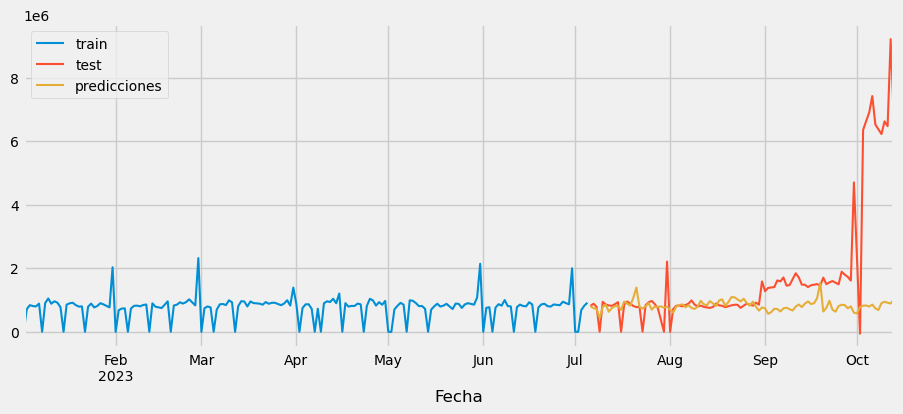

In [22]:
fig, ax = plt.subplots(figsize=(10, 4))
datos_train['ValorVenta'].plot(ax=ax, label='train')
datos_test['ValorVenta'].plot(ax=ax, label='test')
predicciones.plot(ax=ax, label='predicciones')
ax.legend();

## Error de las predicciones en el conjunto de test

##### Se cuantifica el error que comete el modelo en sus predicciones. En este caso, se emplea como métrica el mean squared error (mse).

In [23]:
error_mse = mean_squared_error(
                y_true = datos_test['ValorVenta'],
                y_pred = predicciones
            )

print(f"Error de test (mse): {error_mse}")

Error de test (mse): 4493730431109.822
